# First steps with xmovie

In [18]:
import warnings

import matplotlib.pyplot as plt
import xarray as xr
from shapely.errors import ShapelyDeprecationWarning
from xmovie import Movie

warnings.filterwarnings(
    action='ignore',
    category=ShapelyDeprecationWarning,  # in cartopy
)
warnings.filterwarnings(
    action="ignore",
    category=UserWarning,
    message=r"No `(vmin|vmax)` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `\1` to avoid this step"
)

%matplotlib inline

## Basics

In [23]:
# Load test dataset
ds = xr.tutorial.open_dataset('air_temperature').isel(time=slice(0, 150))

# Create movie object
mov = Movie(ds.air)

### Preview movie frames

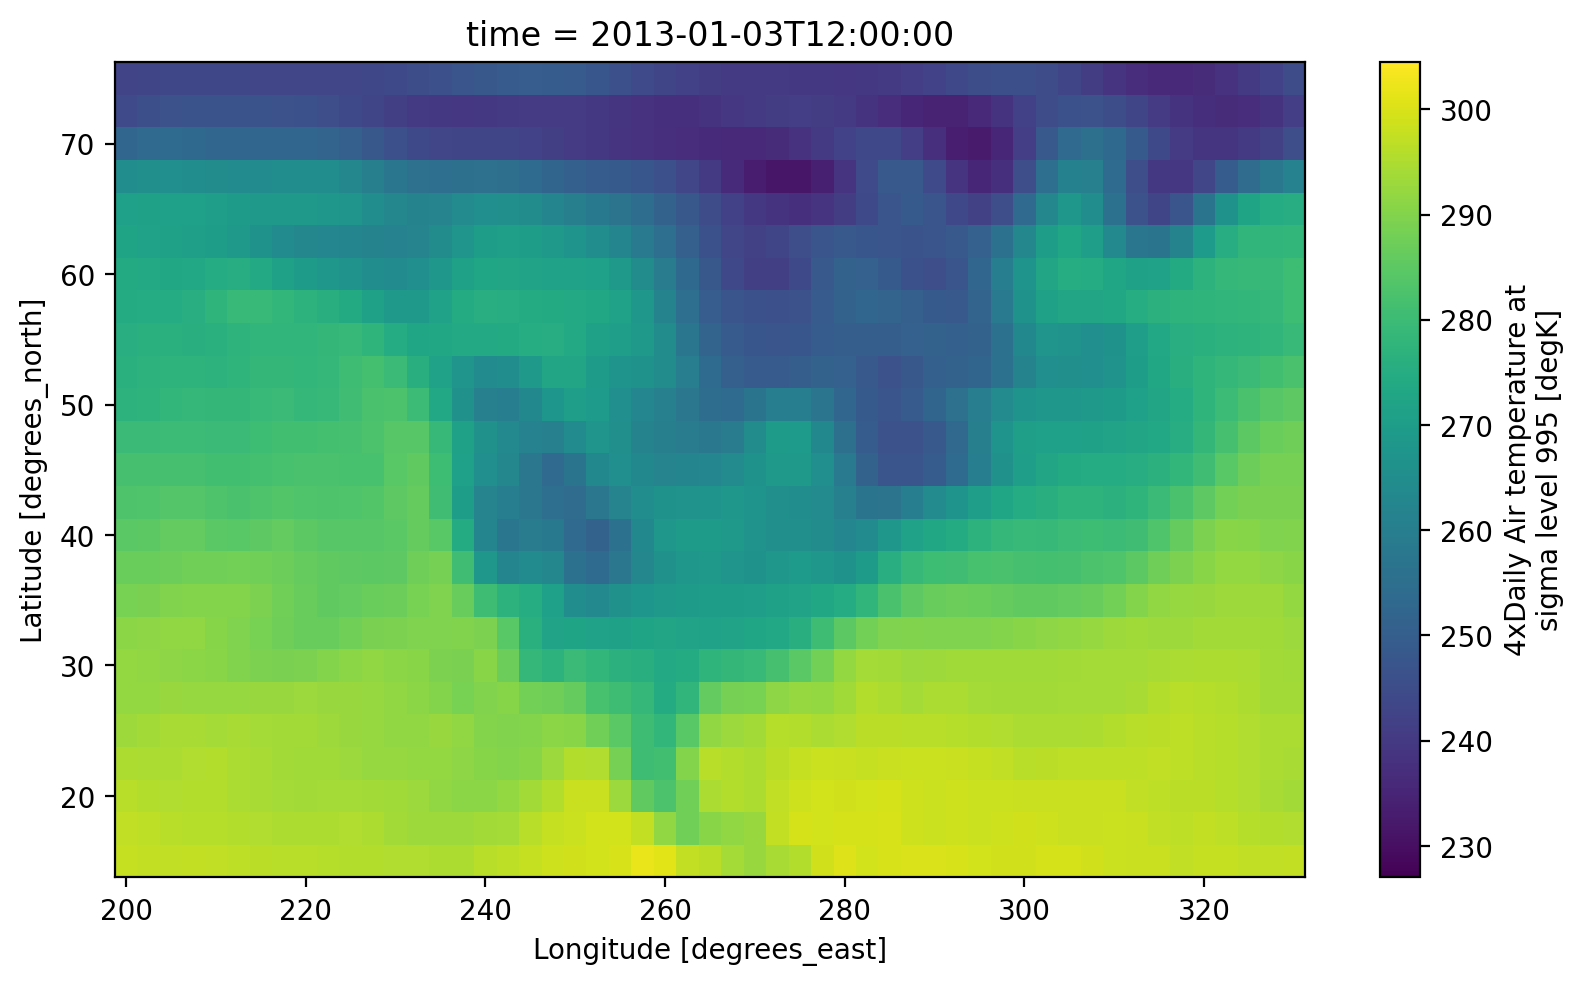

In [20]:
# Preview 10th frame
mov.preview(10)
plt.savefig("movie_preview.png")

In [4]:
! rm -f frame*.png *.mp4 *.gif

rm: cannot remove 'frame*.png': No such file or directory
rm: cannot remove '*.mp4': No such file or directory
rm: cannot remove '*.gif': No such file or directory


### Create movie files

In [5]:
mov.save('movie.mp4')      # Use to save a high quality mp4 movie
mov.save('movie_gif.gif')  # Use to save a gif

Movie created at movie.mp4
Movie created at movie_mp4.mp4
GIF created at movie_gif.gif


In many cases it is useful to have both a high quality movie and a lower resolution gif of the same animation. If that is desired, just deactivate the `remove_movie` option and give a filename with `.gif`. xmovie will first render a high quality movie and then convert it to a gif, without removing the movie afterwards.

### Optional frame-generation progress bars

Display a progressbar with `progress=True`, (requires tqdm). This can be helpful for long running animations.

In [6]:
mov.save('movie_combo.gif', remove_movie=False, progress=True)

  0%|          | 0/150 [00:00<?, ?it/s]

Movie created at movie_combo.mp4
GIF created at movie_combo.gif


Modify the framerate of the output with the keyword arguments `framerate` (for movies) and `gif_framerate` (for gifs).

In [7]:
mov.save('movie_fast.gif', remove_movie=False, progress=True, framerate=20, gif_framerate=20)
mov.save('movie_slow.gif', remove_movie=False, progress=True, framerate=5, gif_framerate=5)

  0%|          | 0/150 [00:00<?, ?it/s]

Movie created at movie_fast.mp4
GIF created at movie_fast.gif


  0%|          | 0/150 [00:00<?, ?it/s]

Movie created at movie_slow.mp4
GIF created at movie_slow.gif


![fast GIF](movie_fast.gif)
![slow GIF](movie_slow.gif)

![combo GIF](movie_combo.gif)

### Frame dimension selection

By default, the movie passes through the `'time'` dimension of the DataArray, but this can be easily changed with the `framedim` argument:

In [24]:
mov = Movie(ds.air, framedim='lon')
mov.save('lon_movie.gif')

Movie created at lon_movie.mp4
GIF created at lon_movie.gif


![lon dim GIF](lon_movie.gif)

## Modifying plots

### Rotating globe (preset)

In [8]:
from xmovie.presets import rotating_globe

mov = Movie(ds.air, plotfunc=rotating_globe)
mov.save('movie_rotating.gif', progress=True)

  0%|          | 0/150 [00:00<?, ?it/s]

Movie created at movie_rotating.mp4
GIF created at movie_rotating.gif


![rotating GIF](movie_rotating.gif)

In [9]:
mov = Movie(ds.air, plotfunc=rotating_globe, style='dark')
mov.save('movie_rotating_dark.gif', progress=True)

  0%|          | 0/150 [00:00<?, ?it/s]

Movie created at movie_rotating_dark.mp4
GIF created at movie_rotating_dark.gif


![rotating dark GIF](movie_rotating_dark.gif)

### Specifying xarray plot method to be used

Change the plotting function with the parameter `plotmethod`.

In [10]:
mov = Movie(ds.air, rotating_globe, plotmethod='contour')
mov.save('movie_cont.gif')

mov = Movie(ds.air, rotating_globe, plotmethod='contourf')
mov.save('movie_contf.gif')

Movie created at movie_cont.mp4
GIF created at movie_cont.gif
Movie created at movie_contf.mp4
GIF created at movie_contf.gif


![rotating contour GIF](movie_cont.gif)
![rotating contourf GIF](movie_contf.gif)

### Changing preset settings

In [11]:
import numpy as np
ds = xr.tutorial.open_dataset('rasm', decode_times=False).Tair  # 36 times in total

# Interpolate time for smoother animation
ds['time'].values[:] = np.arange(len(ds['time']))
ds = ds.interp(time=np.linspace(0, 10, 60))

# `Movie` accepts keywords for the xarray plotting interface and provides a set of 'own' keywords like 
# `coast`, `land` and `style` to facilitate the styling of plots
mov = Movie(ds, rotating_globe,
            # Keyword arguments to the xarray plotting interface
            cmap='RdYlBu_r',
            x='xc',
            y='yc',
            shading='auto',
            # Custom keyword arguments to `rotating_globe
            lat_start=45,
            lat_rotations=0.05,
            lon_rotations=0.2,
            land=False,
            coastline=True,
            style='dark')
mov.save('movie_rasm.gif', progress=True)

  0%|          | 0/60 [00:00<?, ?it/s]

Movie created at movie_rasm.mp4
GIF created at movie_rasm.gif


![RASM GIF](movie_rasm.gif)

### User-provided

Besides the presets, xmovie is designed to animate any custom plot which can be wrapped in a function acting on a matplotlib figure. This can contain xarray plotting commands, 'pure' matplotlib or a combination of both. This can come in handy when you want to animate a complex static plot.

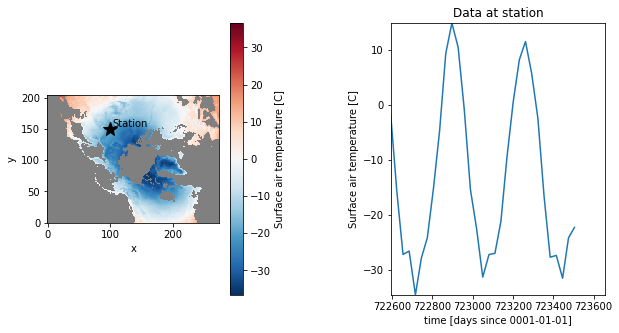

In [21]:
ds = xr.tutorial.open_dataset('rasm', decode_times=False).Tair
fig = plt.figure(figsize=[10,5])
tt = 30

station = dict(x=100, y=150)
ds_station = ds.sel(**station)

(ax1, ax2) = fig.subplots(ncols=2)
ds.isel(time=tt).plot(ax=ax1)
ax1.plot(station['x'], station['y'], marker='*', color='k' ,markersize=15)
ax1.text(station['x']+4, station['y']+4, 'Station', color='k' )
ax1.set_aspect(1)
ax1.set_facecolor('0.5')
ax1.set_title('');

# Time series
ds_station.isel(time=slice(0,tt+1)).plot.line(ax=ax2, x='time')
ax2.set_xlim(ds.time.min().data, ds.time.max().data)
ax2.set_ylim(ds_station.min(), ds_station.max())
ax2.set_title('Data at station');

fig.subplots_adjust(wspace=0.6)

fig.savefig("static.png")

All you need to do is wrap your plotting calls into a functions `func(ds, fig, frame)`, where ds is an xarray dataset you pass to `Movie`, fig is a matplotlib.figure handle and tt is the movie frame.

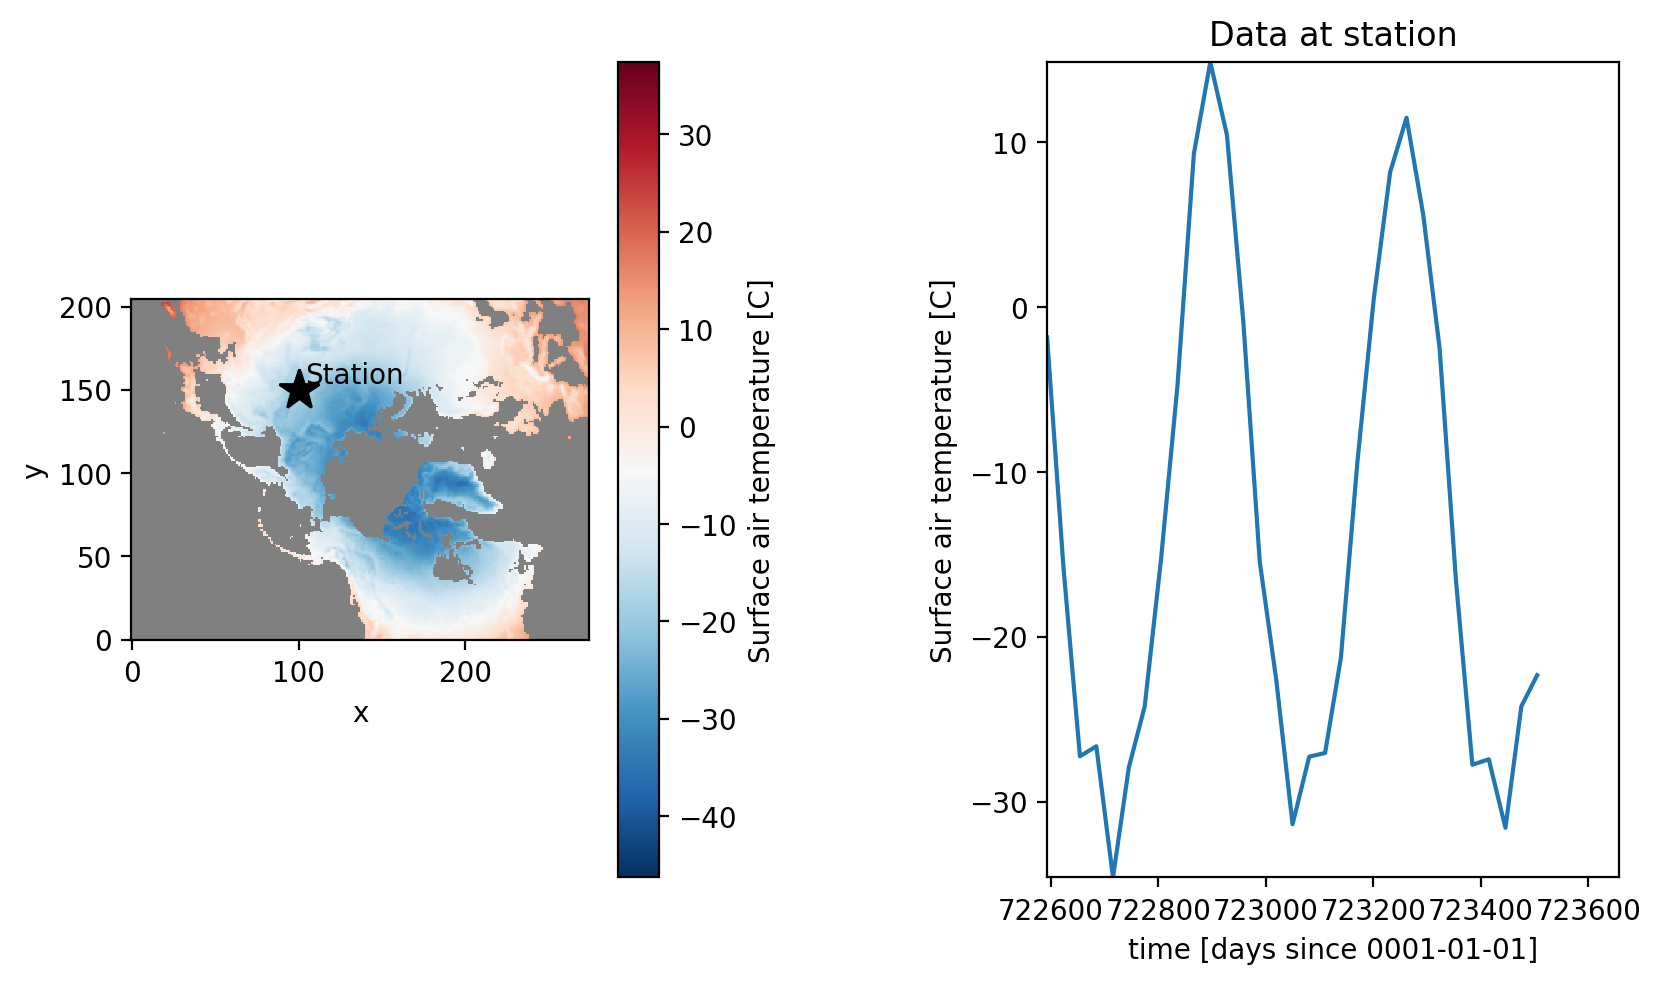

In [13]:
def custom_plotfunc(ds, fig, tt, *args, **kwargs):
    # Define station location for timeseries
    station = dict(x=100, y=150)
    ds_station = ds.sel(**station)

    (ax1, ax2) = fig.subplots(ncols=2)
    
    # Map axis
    # Colorlimits need to be fixed or your video is going to cause seizures.
    # This is the only modification from the code above!
    ds.isel(time=tt).plot(ax=ax1, vmin=ds.min(), vmax=ds.max(), cmap='RdBu_r')
    ax1.plot(station['x'], station['y'], marker='*', color='k' ,markersize=15)
    ax1.text(station['x']+4, station['y']+4, 'Station', color='k' )
    ax1.set_aspect(1)
    ax1.set_facecolor('0.5')
    ax1.set_title('');

    # Time series
    ds_station.isel(time=slice(0,tt+1)).plot.line(ax=ax2, x='time')
    ax2.set_xlim(ds.time.min().data, ds.time.max().data)
    ax2.set_ylim(ds_station.min(), ds_station.max())
    ax2.set_title('Data at station');

    fig.subplots_adjust(wspace=0.6)
    
    return None, None 
    # ^ This is not strictly necessary, but otherwise a warning will be raised.  


mov_custom = Movie(ds, custom_plotfunc)
mov_custom.preview(30)

In [14]:
mov_custom.save('movie_custom.gif', progress=True) 

  0%|          | 0/36 [00:00<?, ?it/s]

Movie created at movie_custom.mp4
GIF created at movie_custom.gif


![custom plotfunc movie](movie_custom.gif)